In [1]:
import sys

ssh = True
if ssh:
    data_folder = "/home/gperri-ext/master_thesis/data//"
    sys.path.append('/home/gperri-ext/master_thesis/')
else:
    data_folder = r"C:\Users\Giova\thesis\master_thesis\data//"
    sys.path.append(r"C:\Users\Giova\thesis\master_thesis//")



import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


import keras_tuner as kt
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


from modules.evaluation_func import single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries, NMAE_error
from modules.visualization import plot_model_loss, plot_error_metrics_barchart, plot_model_rmse_and_loss
from modules.windowing_data import multivariate_data, prepare_dataset_for_training
from modules.temp_features import make_yearly_dataset, create_cyclic_features, transform_time_features
from modules.daily_errors import errors_on_rows, visualize_errors_with_timestamps, filter_errors_at_midnight, calculate_mae_errors, calculate_mape_errors, calculate_rmse_errors, calculate_nmae_errors


from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


2024-04-20 13:27:46.328084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing data

In [2]:
file_name = "df_Italia.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [3]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
df['holiday_d+1'] = df['holiday'].shift(-1, freq=pd.DateOffset(days=-1))
df.dropna(inplace=True)
df.drop(['holiday'], axis=1, inplace=True)

In [5]:
df.head()

,PUN,Italia_load,TOTAL-SOLAR,TOTAL-WIND,GAS,Ora,GiornoSettimana,PUN_d+1-7,holiday_d+1
Time_data,,,,,,,,,
2018-01-21 00:00:00+00:00,38.75,25884.59,0.0,3941.0,19.37,1,6,41.56,1.0
2018-01-21 01:00:00+00:00,34.99,24147.61,0.0,4169.0,19.37,2,6,35.15,1.0
2018-01-21 02:00:00+00:00,30.00,23063.70,0.0,4371.0,19.37,3,6,32.55,1.0
2018-01-21 03:00:00+00:00,27.71,22583.78,0.0,4541.0,19.37,4,6,32.78,1.0
2018-01-21 04:00:00+00:00,25.56,22387.10,0.0,4634.0,19.37,5,6,32.55,1.0


In [6]:
dataset_input = make_yearly_dataset(df, 2018, 2020)

In [7]:
target_size = 24
past_history = 24 
train_size = 0.7
test_size = 0.3

train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

univariate = False

X, y = prepare_dataset_for_training(dataset_input, target_column='PUN', univariate=univariate)
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()

step = 1

X_train, y_train = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=0, 
                                    end_index=train_index, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    past_history, target_size,
                                    step=step, start_index=train_index,
                                    single_step=False)


# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


y_test_inv = y_sc.inverse_transform(y_test)
# input_shape = X_train.shape[-2:]


X_train shape: (18028, 24, 8)
y_train shape: (18028, 24)
X_test shape: (7700, 24, 8)
y_test shape: (7700, 24)


Example

In [8]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

from attention import Attention


## Informer Keras

### ProbSparse Self-Attention:
Self-attention involves computing a weighted sum of all values in the sequence, based on the dot product between the query and key. In ProbSparse, we don’t compute this for all query-key pairs, but rather select dominant ones, thus making the computation more efficient. The given code defines a custom Keras layer, ProbSparseSelfAttention, which implements the multi-head self-attention mechanism, a critical component of Transformer models. This layer initializes three dense networks for the Query, Key, and Value matrices, and splits the input data into multiple heads to enable parallel processing. During the forward pass (call method), the Query, Key, and Value matrices are calculated, scaled, and then used to compute attention scores. These scores indicate the importance of each element in the sequence when predicting another element. The output is a weighted sum of the input values, which is then passed through another dense layer to produce the final result.

La self-attention consiste in una somma ponderata di tutti i valori nella sequenza, basata sui prodotti scalari di query e key e risulta essere inefficiente per lunghe time series. 
La ProbSparse self-attention è una variante della self-attention che cerca di migliorare l'efficienza computazionale selezionando solo le coppie di query e chiave più rilevanti per il calcolo dei punteggi di attenzione. Questo significa che anziché calcolare il prodotto scalare tra ogni coppia di query e chiave, vengono selezionate solo le coppie più importanti in base a determinati criteri, riducendo così il numero complessivo di calcoli necessari e rendendo il processo di self-attention più efficiente.

In [9]:
class ProbSparseSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(ProbSparseSelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        # Assert that d_model is divisible by num_heads
        assert self.d_model % self.num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"

        self.depth = d_model // self.num_heads

        # Defining the dense layers for Query, Key and Value
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Fixing matrix multiplication
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        d_k = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))

        return self.dense(concat_attention)


### Informer Encoder:
The InformerEncoder is a custom Keras layer designed to process sequential data using a combination of attention and convolutional mechanisms. Within the encoder, the input data undergoes multi-head self-attention, utilizing the ProbSparseSelfAttention mechanism, to capture relationships in the data regardless of their distance. Post attention, the data is transformed and normalized, then further processed using two 1D convolutional layers, emphasizing local features in the data. After another normalization step, the processed data is pooled to a lower dimensionality, ensuring the model captures global context, and then passed through a dense layer to produce the final output.

In [10]:
class InformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, conv_filters, **kwargs):
        super(InformerEncoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads

        # Assert that d_model is divisible by num_heads
        assert self.d_model % self.num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"

        self.self_attention = ProbSparseSelfAttention(d_model=d_model, num_heads=num_heads)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # This dense layer will transform the input 'x' to have the dimensionality 'd_model'
        self.dense_transform = tf.keras.layers.Dense(d_model)

        self.conv1 = tf.keras.layers.Conv1D(conv_filters, 3, padding='same')
        self.conv2 = tf.keras.layers.Conv1D(d_model, 3, padding='same')
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, x):
        attn_output = self.self_attention(x, x, x)

        # Transform 'x' to have the desired dimensionality
        x_transformed = self.dense_transform(x)
        attn_output = self.norm1(attn_output + x_transformed)

        conv_output = self.conv1(attn_output)
        conv_output = tf.nn.relu(conv_output)
        conv_output = self.conv2(conv_output)

        encoded_output = self.norm2(conv_output + attn_output)

        pooled_output = self.global_avg_pooling(encoded_output)
        return self.dense(pooled_output)[:, -4:]

In [11]:
n_features = X_train.shape[-1]
input_layer = tf.keras.layers.Input(shape=(past_history, n_features))

# Encoder
encoder_output = InformerEncoder(d_model=360, num_heads=8, conv_filters=64)(input_layer)

# Decoder (with attention)
decoder_lstm = tf.keras.layers

2024-04-20 13:27:51.837433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11539 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


The InformerModel function is designed to create a deep learning architecture tailored for sequential data prediction. It takes an input sequence and processes it using the InformerEncoder, a custom encoder layer, which captures both local and global patterns in the data. Following the encoding step, a decoder structure unravels the encoded data by first repeating the encoder’s output, then passing it through an LSTM layer to retain sequential dependencies, and finally making predictions using a dense layer. The resulting architecture is then compiled with the Adam optimizer and Mean Squared Error loss, ready for training on time series data.

In [12]:
input_shape = (past_history, X_train.shape[-1])

In [13]:
def InformerModel(input_shape, d_model=64, num_heads=2, conv_filters=256, learning_rate= 1e-3):
    # Input
    input_layer = Input(shape=input_shape)

    # Encoder
    encoder_output = InformerEncoder(d_model=d_model, num_heads=num_heads, conv_filters=conv_filters)(input_layer)

    # Decoder
    repeated_output = RepeatVector(target_size)(encoder_output)  # Repeating encoder's output
    decoder_lstm = LSTM(30, return_sequences=True)(repeated_output)
    decoder_output = Dense(target_size)(decoder_lstm[:, -1, :])  # Use the last sequence output to predict the next value

    # Model
    model = Model(inputs=input_layer, outputs=decoder_output)
    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [14]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.keras.backend.clear_session()

# Parametri del modello
num_layers = 4  # Numero di livelli di encoder
d_model = 360
num_heads = 8
conv_filters = 64
target_size = 24  # Dimensione dell'output finale

# Costruzione del modello
model = InformerModel(input_shape, d_model, num_heads, conv_filters, target_size)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 8)]           0         
                                                                 
 informer_encoder (Informer  (None, 4)                 412984    
 Encoder)                                                        
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 4)             0         
 r)                                                              
                                                                 
 lstm (LSTM)                 (None, 24, 30)            4200      
                                                                 
 tf.__operators__.getitem (  (None, 30)                0         
 SlicingOpLambda)                                                
                                                             

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='trial_best.h5', monitor='val_loss', verbose=1, save_best_only=True)


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.3,
    shuffle=False,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50


2024-04-20 13:27:55.245023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-04-20 13:27:56.856341: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


198/198 [==============================] - 47s 200ms/step - loss: 0.0152 - val_loss: 0.0064
Epoch 2/50
198/198 [==============================] - 39s 199ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 3/50
198/198 [==============================] - 40s 201ms/step - loss: 0.0065 - val_loss: 0.0052
Epoch 4/50
198/198 [==============================] - 39s 195ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 5/50
198/198 [==============================] - 40s 201ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 6/50
198/198 [==============================] - 39s 195ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 7/50
198/198 [==============================] - 40s 200ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 8/50
 17/198 [=>............................] - ETA: 32s - loss: 0.0117

KeyboardInterrupt: 

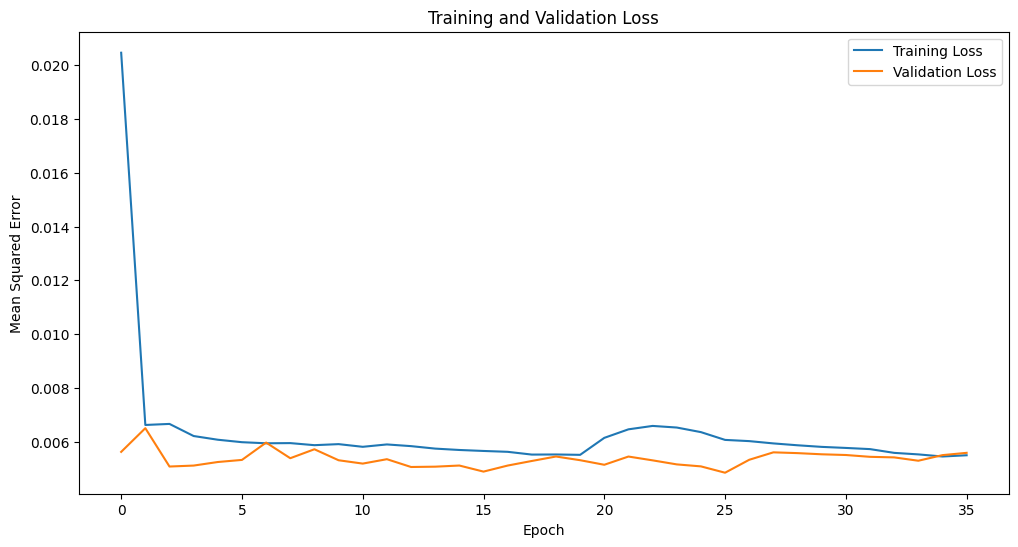

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [ ]:
test_predictions = model.predict(X_test)

241/241 [==============================] - 8s 35ms/step


In [ ]:
from sklearn.metrics import mean_squared_error

test_predictions_inv = y_sc.inverse_transform(test_predictions)
y_test_inv = y_sc.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, test_predictions_inv)
print(f"Test MSE: {mse}")

Test MSE: 241.9193898562064


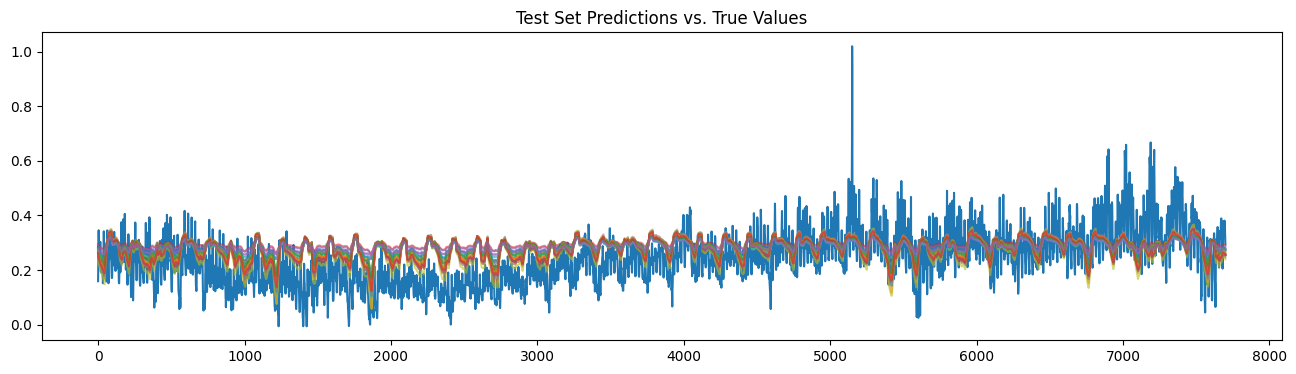

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot()
plt.plot(y_test[:,0], label='True Values')
plt.plot(test_predictions, label='Predictions', alpha=0.6)
plt.title('Test Set Predictions vs. True Values')
# plt.legend()
plt.show()

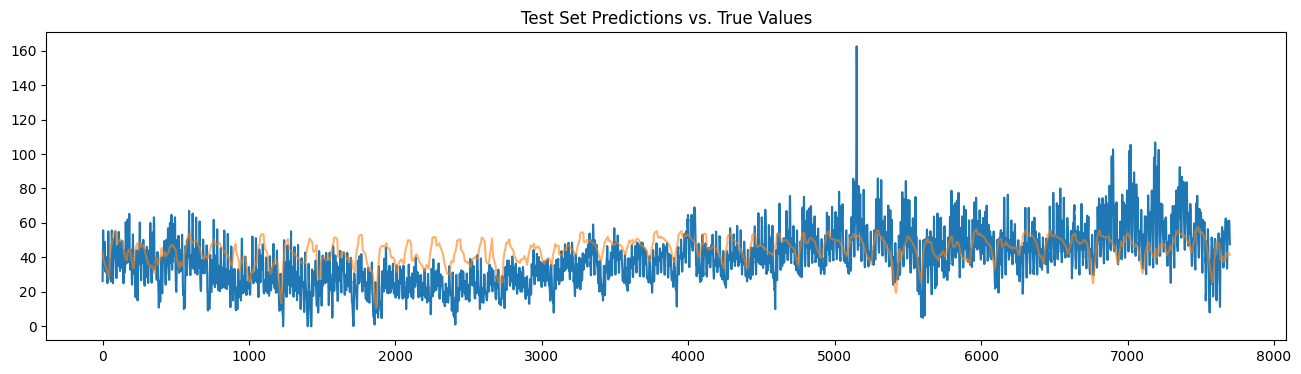

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot()
plt.plot(y_test_inv[:,0], label='True Values')
plt.plot(test_predictions_inv[:,0], label='Predictions', alpha=0.6)
plt.title('Test Set Predictions vs. True Values')
# plt.legend()
plt.show()

### Hyperparameters search

In [ ]:
from tensorflow.keras.layers import Input, RepeatVector, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import kerastuner as kt

In [ ]:
def build_model(hp):
    # Input
    input_layer = Input(shape=(past_history, n_features))

    # Encoder
    encoder_output = InformerEncoder(d_model=hp.Int('d_model', min_value=32, max_value=512, step=16),
                                     num_heads=hp.Int('num_heads', 2, 8, step=2),
                                     conv_filters=hp.Int('conv_filters', min_value=16, max_value=256, step=16))(input_layer)

    # Decoder
    repeated_output = RepeatVector(target_size)(encoder_output)  # Repeating encoder's output
    decoder_lstm = LSTM(100, return_sequences=True)(repeated_output)
    decoder_output = Dense(target_size)(decoder_lstm[:, -1, :])  # Use the last sequence output to predict the next value

    # Model
    model = Model(inputs=input_layer, outputs=decoder_output)

    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-2, 1e-1]))
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


In [ ]:

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=5,
    directory='hyperparam_search',
    project_name='informer_model_tmux',
    overwrite=True
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='trial_best_tmux.h5', monitor='val_loss', verbose=1, save_best_only=True)


tuner.search(X_train, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping, model_checkpoint])


Trial 2 Complete [00h 00m 44s]

Best val_loss So Far: 0.003701712284237146
Total elapsed time: 03h 38m 34s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |48                |d_model
2                 |4                 |num_heads
192               |160               |conv_filters
0.01              |0.01              |learning_rate

Epoch 1/50
451/451 [==============================] - ETA: 0s - loss: 0.0095
Epoch 1: val_loss improved from inf to 0.00634, saving model to trial_best_tmux.h5
451/451 [==============================] - 103s 228ms/step - loss: 0.0095 - val_loss: 0.0063
Epoch 2/50
451/451 [==============================] - ETA: 0s - loss: 0.0046
Epoch 2: val_loss improved from 0.00634 to 0.00549, saving model to trial_best_tmux.h5
451/451 [==============================] - 102s 227ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 3/50
451/451 [==============================] - ETA: 0s - loss: 0.0043
Epoch 3: val_loss improved f

KeyboardInterrupt: 

In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Retrieve the best model
best_model = tuner.get_best_models()[0]
best_model.summary()


In [ ]:
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss}")

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(true_values.shape[1]):
    plt.subplot(2, 2, i+1)
    plt.plot(true_values[:, i], label='True Values', color='blue')
    plt.plot(test_predictions[:, i], label='Predictions', color='red', linestyle='--')
    plt.title(f"Feature {i+1}")
    plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(true_values, test_predictions)
rmse = np.sqrt(test_loss)  # since loss is MSE
print(f"MAE: {mae}, RMSE: {rmse}")

print(f"Best d_model: {best_hp.get('d_model')}")
print(f"Best num_heads: {best_hp.get('num_heads')}")
print(f"Best conv_filters: {best_hp.get('conv_filters')}")
print(f"Best learning_rate: {best_hp.get('learning_rate')}")


In [ ]:
# !pip install shap


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
raise KeyboardInterrupt("Fine lettura")

In [ ]:
import shap

# The reference can be a dataset or just random data
background = X_train[np.random.choice(X_train.shape[0], 300, replace=False)]  # Taking a random sample of the training data as background
explainer = shap.GradientExplainer(best_model, background)

shap_values = explainer.shap_values(X_test[:300])  # Computing for a subset for performance reasons

for timestep in range(10):
    print(f"Summary plot for timestep {timestep + 1}")
    shap.summary_plot(shap_values[0][:, timestep, :], X_test[:300, timestep, :])
